In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%matplotlib inline

import itertools
from kernels import HMC_our, HMC_vanilla, Reverse_kernel_sampling
from target import GMM_target, GMM_target2, Funnel, Gaussian_target, Banana
from args import get_args

import matplotlib
matplotlib.rcParams.update({'font.size': 20})

import pdb

In [2]:
args = get_args()

In [3]:
target = GMM_target2(args)
args.data_name = target.__class__.__name__

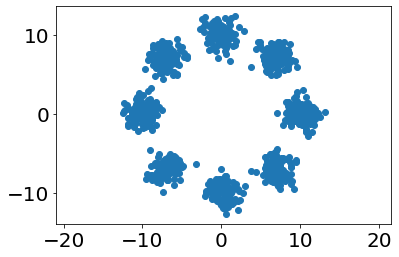

In [4]:
target_samples = target.get_samples(n=1000).cpu().numpy()
plt.scatter(target_samples[:, 0], target_samples[:, 1])
plt.axis('equal');

#### Common setup

In [5]:
## Here we fix K
args.n_steps = args.K # how many samples to use
args.n_warmup = 0 # num of first samples to refuse

args.n_chains = 10 # how many chains to model
args.data_dim = 2
args.z_dim = 2
args.train_batch_size = 500

limit = 10

In [6]:
vanilla_kernel = HMC_vanilla(args)

## Vanilla HMC

In [7]:
q_new = args.std_normal.sample((args.n_chains, args.data_dim))
p_new = args.std_normal.sample((args.n_chains, args.data_dim))
        
print("Now we are running warmup!")
iterator = tqdm(range(args.n_warmup))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
iterator.close()
    
samples_vanilla = torch.empty((args.n_steps, args.n_chains, args.data_dim), device=args.device, dtype=args.torchType)

print("Now we are sampling!")
iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
    samples_vanilla[i] = q_new
iterator.close()

0it [00:00, ?it/s]
100%|██████████| 5/5 [00:00<00:00, 75.45it/s]

Now we are running warmup!
Now we are sampling!


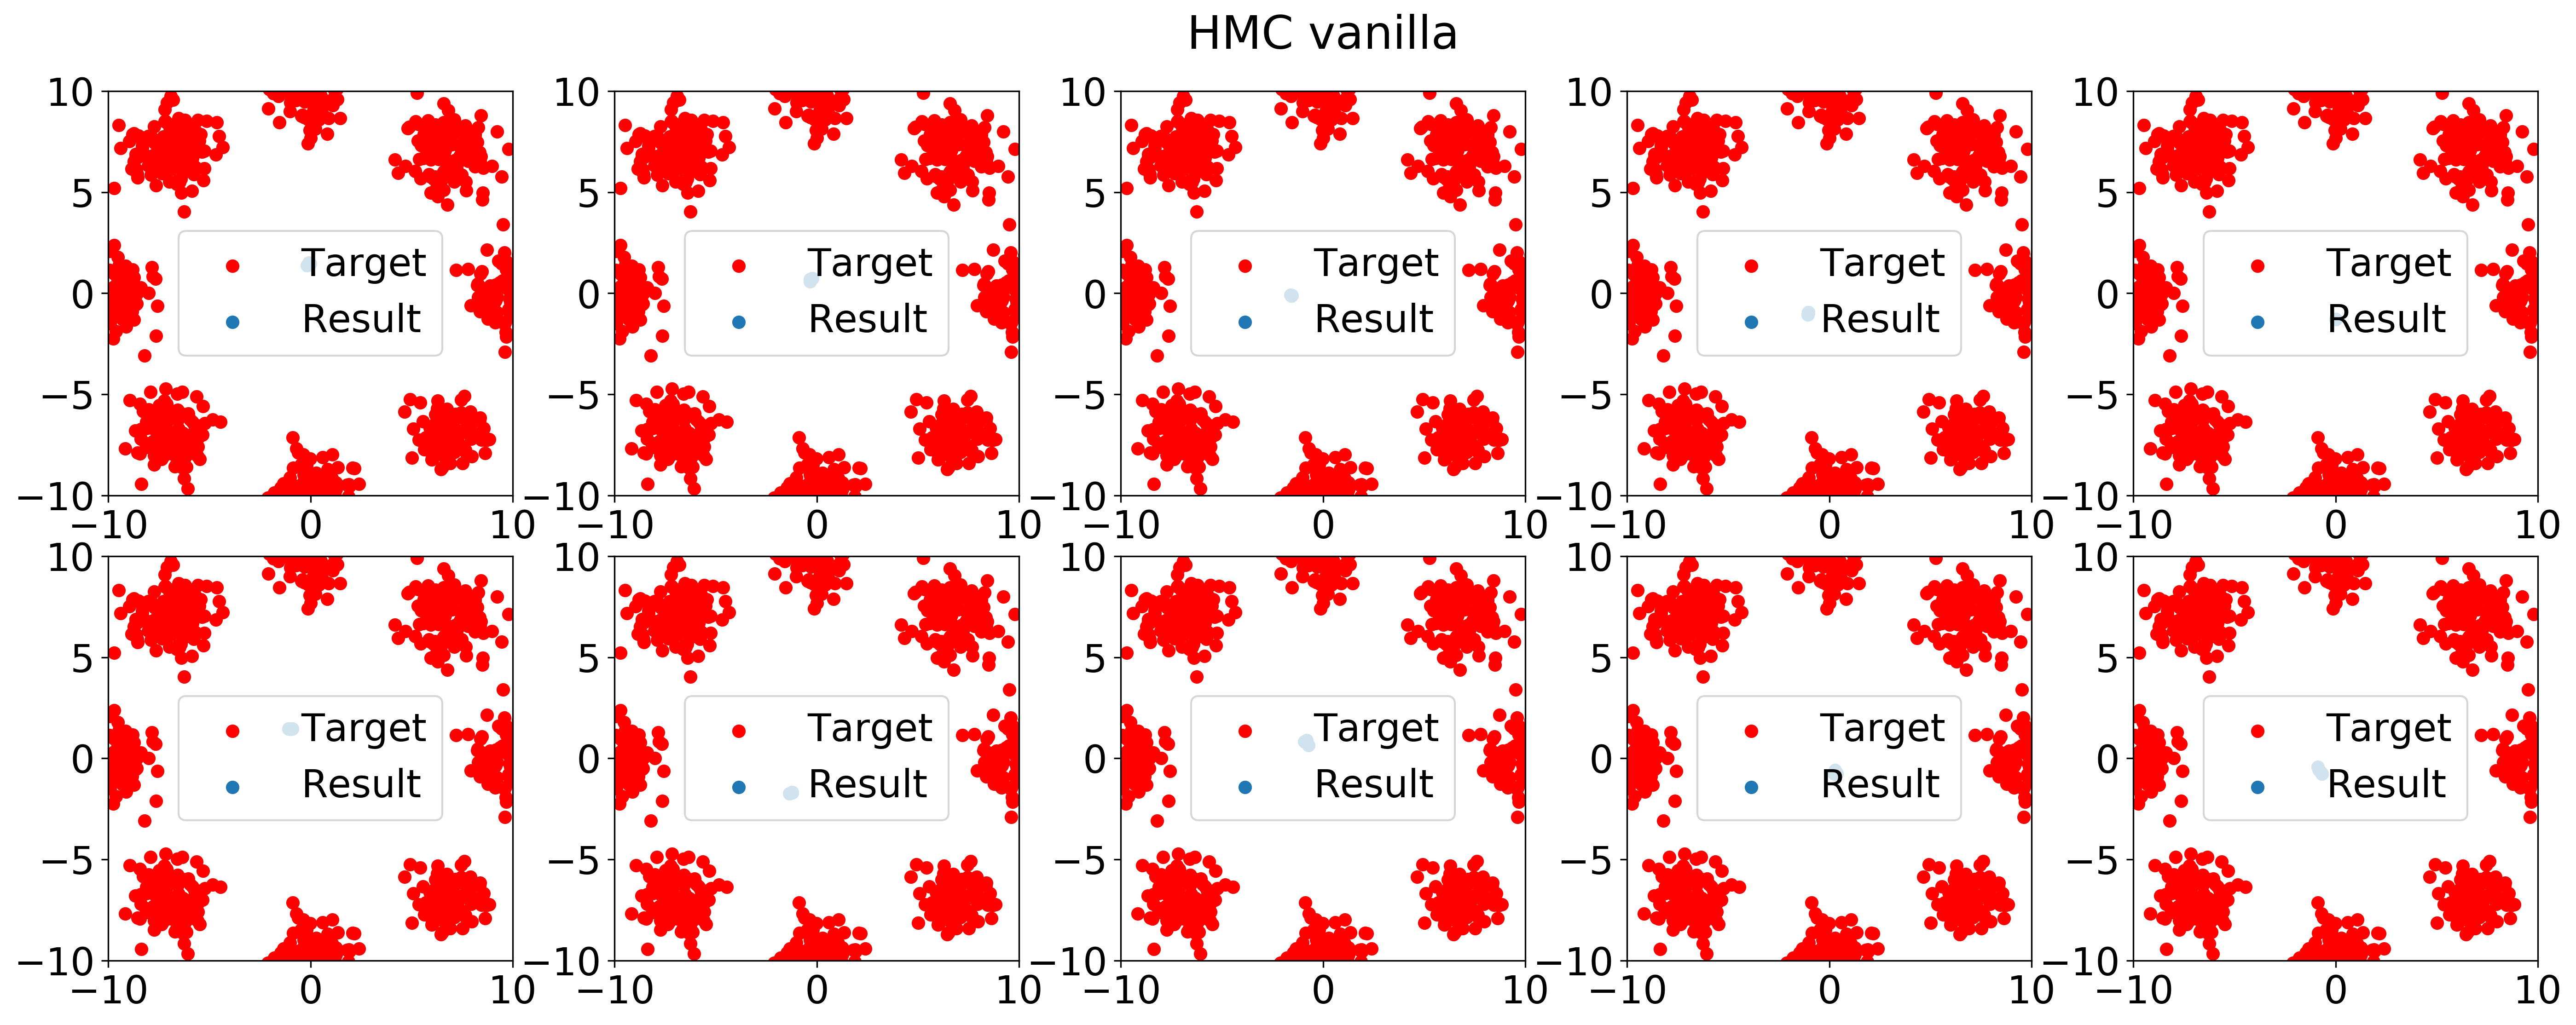

In [8]:
fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
plt.suptitle('HMC vanilla')
for chain_num in range(args.n_chains):
    ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
    ax[chain_num // 5, chain_num % 5].scatter(samples_vanilla[:, chain_num, 0].cpu(), samples_vanilla[:, chain_num, 1].cpu(), label='Result')
    ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_aspect('equal')
    ax[chain_num // 5, chain_num % 5].legend()
plt.tight_layout();
plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)

100%|██████████| 5/5 [00:00<00:00, 78.59it/s]


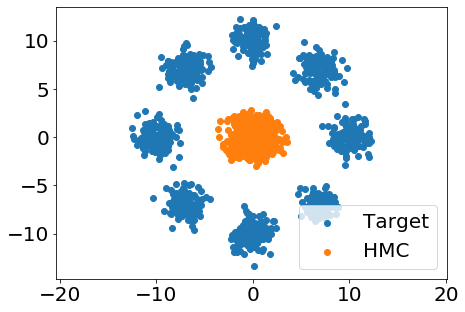

In [9]:
q_new = args.std_normal.sample((target_samples.shape[0], args.z_dim))
p_new = args.std_normal.sample((target_samples.shape[0], args.z_dim))

iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
iterator.close()

plt.figure(figsize=(7, 5))
plt.scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
plt.scatter(q_new.cpu().detach().numpy()[:, 0], q_new.cpu().detach().numpy()[:, 1], label='HMC')
plt.legend()
plt.axis('equal');

## Hoffman HMC

In [10]:
##### Minimize KL first

mu_init_hoff = nn.Parameter(torch.zeros(args.data_dim, device=args.device, dtype=args.torchType))
sigma_init_hoff = nn.Parameter(torch.ones(args.data_dim, device=args.device, dtype=args.torchType))
optimizer = torch.optim.Adam(params=[mu_init_hoff, sigma_init_hoff], lr=args.learning_rate)

init_distr = torch.distributions.Normal(loc=mu_init_hoff, scale=nn.functional.softplus(sigma_init_hoff))
for i in tqdm(range(20000)):
#     pdb.set_trace()
    u_init =  args.std_normal.sample((500,args.data_dim ))
    q_init = mu_init_hoff + nn.functional.softplus(sigma_init_hoff) * u_init

    current_kl = args.std_normal.log_prob(u_init).sum(1) - torch.sum(nn.functional.softplus(sigma_init_hoff).log()) - target.get_logdensity(z=q_init)
    torch.mean(current_kl).backward() ## minimize KL
    optimizer.step()
    optimizer.zero_grad()
    if i % 2000 == 0:
        print(current_kl.mean().cpu().detach().numpy())

  0%|          | 46/20000 [00:00<01:27, 228.78it/s]

35.52753


 10%|█         | 2025/20000 [00:08<01:15, 236.60it/s]

16.05408


 20%|██        | 4041/20000 [00:17<01:07, 236.49it/s]

8.87619


 30%|███       | 6033/20000 [00:25<00:58, 236.84it/s]

5.49129


 40%|████      | 8025/20000 [00:34<00:51, 232.86it/s]

2.1893065


 50%|█████     | 10041/20000 [00:42<00:42, 232.34it/s]

2.0790336


 60%|██████    | 12033/20000 [00:51<00:34, 231.41it/s]

2.0791554


 70%|███████   | 14025/20000 [00:59<00:25, 233.53it/s]

2.0795374


 80%|████████  | 16041/20000 [01:08<00:17, 231.91it/s]

2.079126


 90%|█████████ | 18033/20000 [01:17<00:08, 230.50it/s]

2.0793517


100%|██████████| 20000/20000 [01:25<00:00, 233.70it/s]


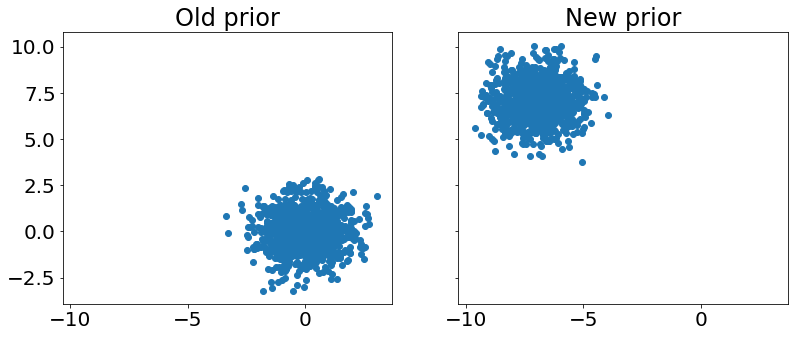

In [11]:
### Plot new prior
prior_old = args.std_normal.sample((1000, 2)).cpu().detach().numpy()

mu_init_hoff.requires_grad_(False)
sigma_init_hoff.requires_grad_(False)
prior_new = mu_init_hoff + args.std_normal.sample((1000, 2)) * nn.functional.softplus(sigma_init_hoff)
prior_new = prior_new.cpu().detach().numpy()

fig, ax = plt.subplots(ncols=2, figsize=(13, 5), sharex=True, sharey=True)
ax[0].scatter(prior_old[:, 0], prior_old[:, 1])
ax[1].scatter(prior_new[:, 0], prior_new[:, 1])
ax[0].set_title('Old prior')
ax[1].set_title('New prior');

In [12]:
### Then run HMC (without warmup) of length K

q_new = mu_init_hoff + args.std_normal.sample((args.n_chains, args.z_dim)) * nn.functional.softplus(sigma_init_hoff)
p_new = args.std_normal.sample((args.n_chains, args.z_dim))
        
print("Now we are running warmup!")
iterator = tqdm(range(args.n_warmup))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
iterator.close()
    
samples_hoffman = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)

print("Now we are sampling!")
iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
    samples_hoffman[i] = q_new
iterator.close()

0it [00:00, ?it/s]
100%|██████████| 5/5 [00:00<00:00, 81.99it/s]

Now we are running warmup!
Now we are sampling!


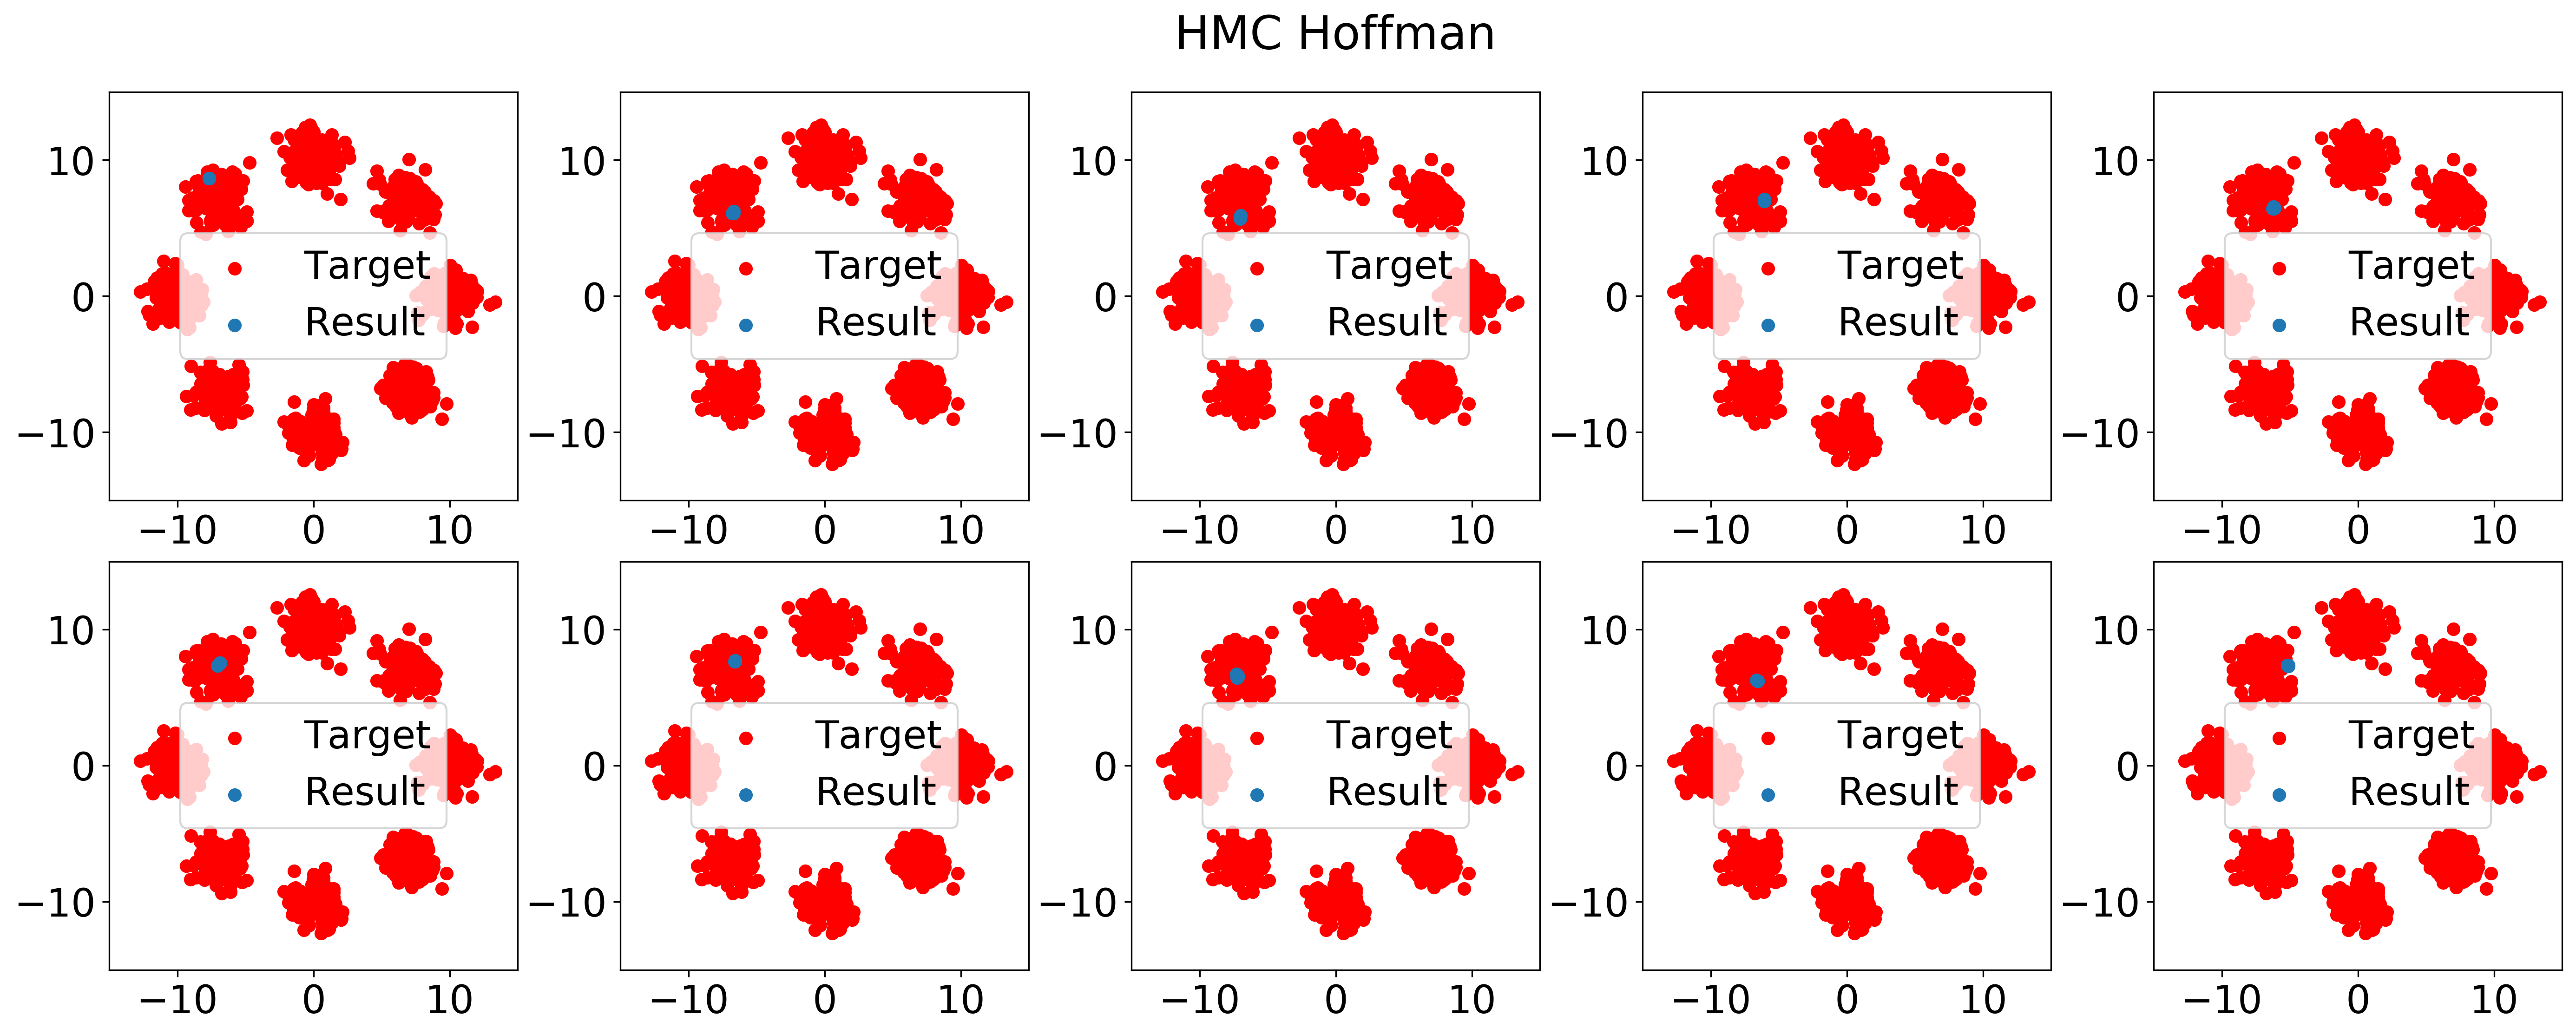

In [13]:
### Plot received chains

limit = 15
fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
plt.suptitle('HMC Hoffman')
for chain_num in range(args.n_chains):
    ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
    ax[chain_num // 5, chain_num % 5].scatter(samples_hoffman[:, chain_num, 0].cpu(), samples_hoffman[:, chain_num, 1].cpu(), label='Result')
    ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_aspect('equal')
    ax[chain_num // 5, chain_num % 5].legend()
plt.tight_layout();
plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)

100%|██████████| 5/5 [00:00<00:00, 80.71it/s]


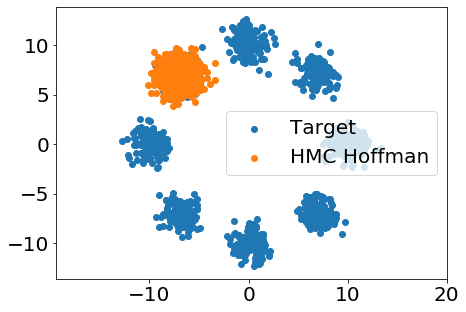

In [14]:
q_new = mu_init_hoff + args.std_normal.sample((target_samples.shape[0], args.z_dim)) * nn.functional.softplus(sigma_init_hoff)
p_new = args.std_normal.sample((target_samples.shape[0], args.z_dim))

iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
iterator.close()

plt.figure(figsize=(7, 5))
plt.scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
plt.scatter(q_new.cpu().detach().numpy()[:, 0], q_new.cpu().detach().numpy()[:, 1], label='HMC Hoffman')
plt.legend()
plt.axis('equal');

## Neutra HMC

In [15]:
##### Minimize KL first

from pyro.nn import AutoRegressiveNN, DenseNN
from pyro.distributions.transforms import NeuralAutoregressive, AffineAutoregressive, AffineCoupling

num_flows = 10
flow_type = 'IAF' # 'RNVP'

flow_list = []
for i in range(num_flows):
    if flow_type == 'IAF':
        one_arn = AutoRegressiveNN(args.data_dim, [2 * args.data_dim]).to(args.device)
        one_flow = AffineAutoregressive(one_arn)
    elif flow_type == 'RNVP':
        hypernet = DenseNN(input_dim=args.data_dim // 2, hidden_dims=[2 * args.data_dim, 2 * args.data_dim],
                param_dims=[args.data_dim - args.z_dim // 2, args.data_dim - args.data_dim // 2]).to(args.device)
        one_flow = AffineCoupling(args.data_dim // 2, hypernet).to(args.device)
    flow_list.append(one_flow)
flows = nn.ModuleList(flow_list)

optimizer = torch.optim.Adam(params=flows.parameters(), lr=args.learning_rate)

for i in tqdm(range(20000)):
#     pdb.set_trace()
    q_new = args.std_normal.sample((100, args.data_dim))
    u = q_new
    q_prev = q_new
    sum_log_jacobian = 0.
    for j in range(len(flows)):
        q_new = flows[j](q_prev)
        sum_log_jacobian += flows[j].log_abs_det_jacobian(q_prev, q_new)
        q_prev = q_new
        
    current_kl = args.std_normal.log_prob(u).sum(1) - sum_log_jacobian - target.get_logdensity(z=q_new)
    torch.mean(current_kl).backward() ## minimize KL
    optimizer.step()
    optimizer.zero_grad()
    if i % 2000 == 0:
        print(current_kl.mean().cpu().detach().numpy())

  0%|          | 17/20000 [00:00<04:10, 79.88it/s]

24.448832


 10%|█         | 2015/20000 [00:24<03:41, 81.28it/s]

2.0397632


 20%|██        | 4009/20000 [00:49<03:18, 80.67it/s]

1.9011123


 30%|███       | 6009/20000 [01:14<02:52, 81.24it/s]

1.8246267


 40%|████      | 8009/20000 [01:39<02:26, 81.77it/s]

1.6740326


 50%|█████     | 10013/20000 [02:03<02:02, 81.81it/s]

1.6937622


 60%|██████    | 12012/20000 [02:28<01:37, 81.68it/s]

1.6452852


 70%|███████   | 14010/20000 [02:53<01:14, 80.43it/s]

1.6020374


 80%|████████  | 16017/20000 [03:18<00:48, 82.01it/s]

1.8521371


 90%|█████████ | 18011/20000 [03:42<00:24, 80.28it/s]

1.6057196


100%|██████████| 20000/20000 [04:07<00:00, 80.82it/s]


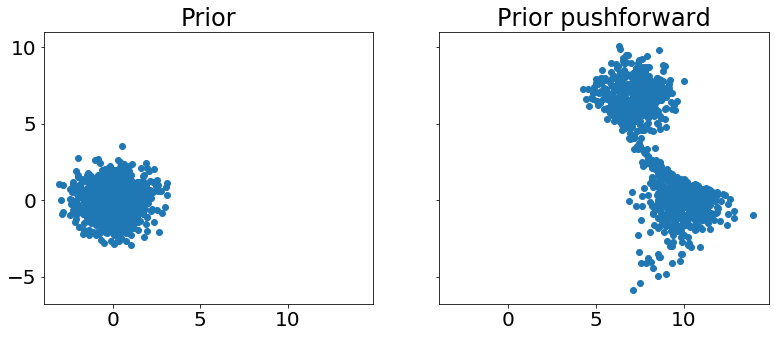

In [16]:
### Plot new prior
prior = args.std_normal.sample((1000, 2))

for p in flows.parameters():
    p.requires_grad_(False)

prior_pushforward = prior
for i in range(len(flows)):
    prior_pushforward = flows[i](prior_pushforward)
prior_pushforward = prior_pushforward.cpu().detach().numpy()
prior = prior.cpu().detach().numpy()

fig, ax = plt.subplots(ncols=2, figsize=(13, 5), sharex=True, sharey=True)
ax[0].scatter(prior[:, 0], prior[:, 1])
ax[1].scatter(prior_pushforward[:, 0], prior_pushforward[:, 1])
ax[0].set_title('Prior')
ax[1].set_title('Prior pushforward');

In [17]:
### Then run HMC (without warmup) of length K in warped space

q_new = args.std_normal.sample((args.n_chains, args.z_dim))
p_new = args.std_normal.sample((args.n_chains, args.z_dim))
        
print("Now we are running warmup!")
iterator = tqdm(range(args.n_warmup))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target, flows=flows)
iterator.close()

samples_neutrahmc = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)

print("Now we are sampling!")
iterator = tqdm(range(args.n_steps))
for i in iterator:
#     pdb.set_trace()
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target, flows=flows)
    ### Pushforward obtained samples in warped space to original space
    q_tr = q_new.detach()
    for j in range(len(flows)):
        q_tr = flows[j](q_tr)
    samples_neutrahmc[i] = q_tr
iterator.close()

0it [00:00, ?it/s]
100%|██████████| 5/5 [00:00<00:00, 44.96it/s]

Now we are running warmup!
Now we are sampling!


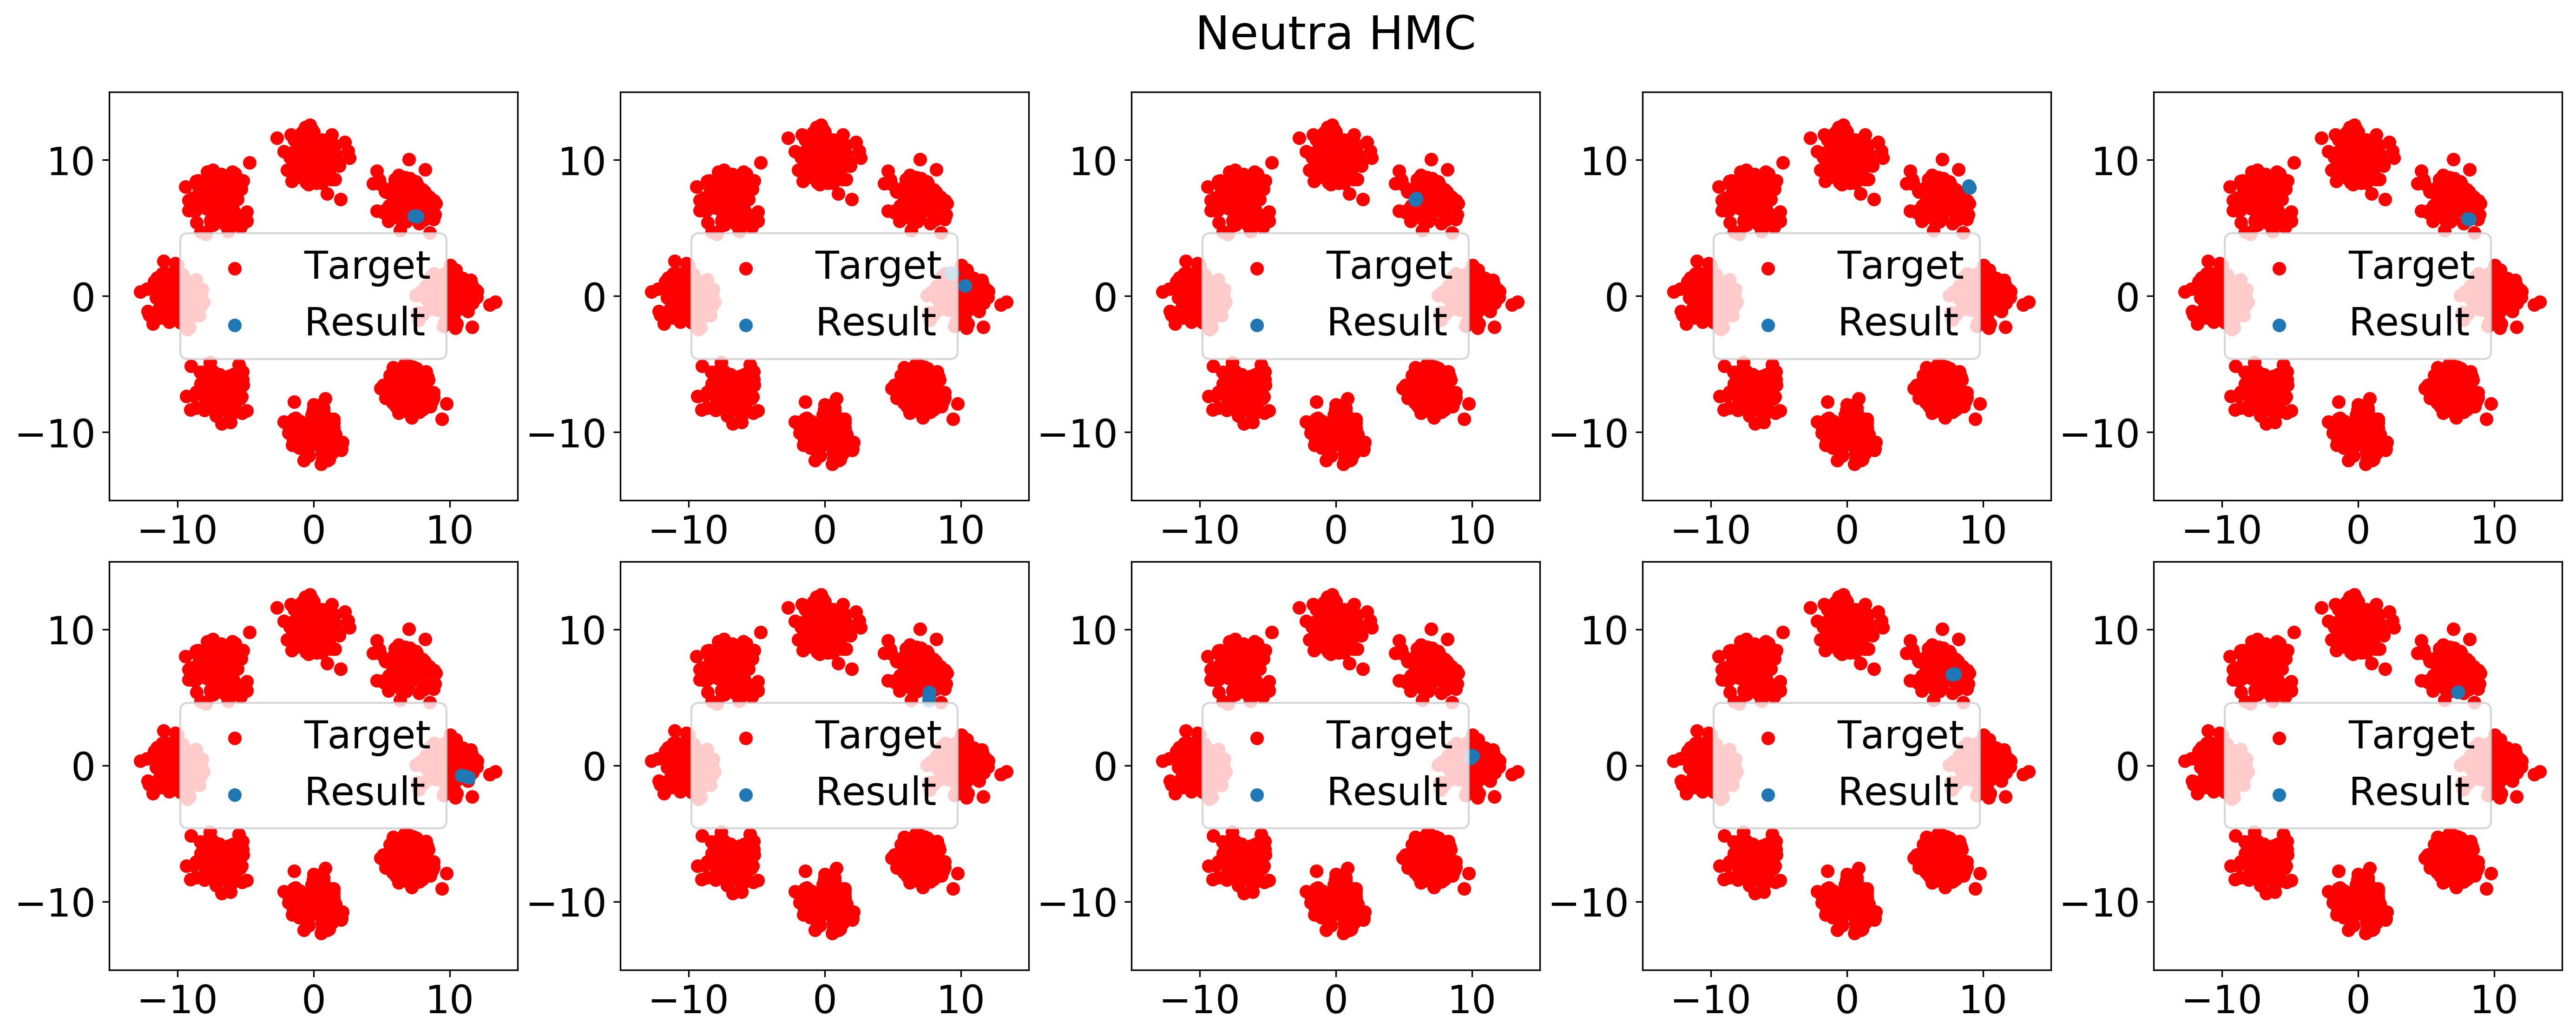

In [18]:
### Plot received chains

limit = 15
fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
plt.suptitle('Neutra HMC')
for chain_num in range(args.n_chains):
    ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
    ax[chain_num // 5, chain_num % 5].scatter(samples_neutrahmc[:, chain_num, 0].cpu(), samples_neutrahmc[:, chain_num, 1].cpu(), label='Result')
    ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_aspect('equal')
    ax[chain_num // 5, chain_num % 5].legend()
plt.tight_layout();
plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)

100%|██████████| 5/5 [00:00<00:00, 48.91it/s]


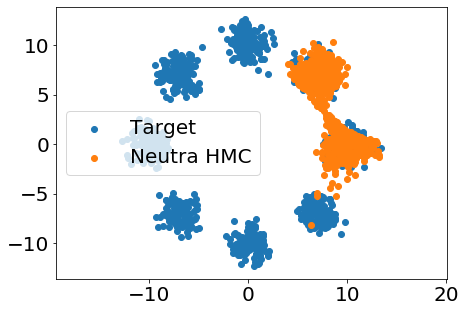

In [19]:
q_new = args.std_normal.sample((target_samples.shape[0], args.z_dim))
p_new = args.std_normal.sample((target_samples.shape[0], args.z_dim))

iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target, flows=flows)
iterator.close()
q_new = q_new.detach()
for j in range(len(flows)):
    q_new = flows[j](q_new)

plt.figure(figsize=(7, 5))
plt.scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
plt.scatter(q_new.cpu().detach().numpy()[:, 0], q_new.cpu().detach().numpy()[:, 1], label='Neutra HMC')
plt.legend()
plt.axis('equal');

## Ours HMC (w/o reparametrization trick)

In [20]:
if args.learnable_reverse:
    reverse_kernel = Reverse_kernel_sampling(kwargs=args).to(args.device)
    reverse_params = reverse_kernel.parameters()
else:
    reverse_params = list([])

if args.amortize:
    transitions = HMC_our(kwargs=args).to(args.device)
    our_kernel_best_wo = HMC_our(kwargs=args).to(args.device)
else:
    transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])
    our_kernel_best_wo = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args.K)])
        
if args.fix_transition_params:
    for p in transitions.parameters():
        transitions.requires_grad_(False)
    
mu_init_wo = nn.Parameter(torch.zeros(args.data_dim, device=args.device, dtype=args.torchType))
sigma_init_wo = nn.Parameter(torch.ones(args.data_dim, device=args.device, dtype=args.torchType))

params = list(transitions.parameters()) + list(reverse_params) + [mu_init_wo, sigma_init_wo]

optimizer = torch.optim.Adam(params=params, lr=args.learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=200, factor=0.9)

  0%|          | 0/20000 [00:00<?, ?it/s]

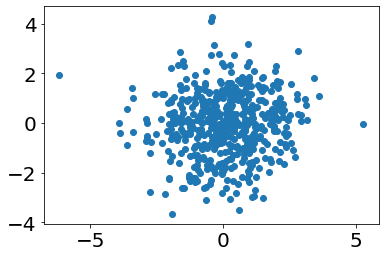

  0%|          | 3/20000 [00:00<43:10,  7.72it/s]

Current lr:  0.001
On batch number 0 ELBO is -42.25575256347656
On batch number 0 Best ELBO is -inf


  5%|▍         | 999/20000 [01:22<26:05, 12.14it/s]

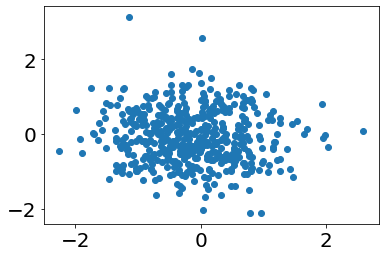

  5%|▌         | 1003/20000 [01:23<30:43, 10.31it/s]

Current lr:  0.0006561000000000001
On batch number 1000 ELBO is -49.50374984741211
On batch number 1000 Best ELBO is -41.523799896240234


  5%|▌         | 1027/20000 [01:25<26:20, 12.00it/s]

Early stopping on 1028


In [21]:
# with torch.autograd.detect_anomaly():
print_info_ = 1000
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)
best_elbo = -float("inf")

x_lim = limit
y_lim = limit

def compute_loss(q_new, p_new, q_old, p_old, sum_log_alpha, sum_log_jac, all_directions=None, mu=None, sigma=None, u=None):
    if args.learnable_reverse:
        log_r = reverse_kernel(z_fin=q_new, a=all_directions)
    else:
        log_r = -args.K * torch_log_2
    log_p = target.get_logdensity(z=q_new) + args.std_normal.log_prob(p_new).sum(1)

    sum_log_sigma = torch.sum(nn.functional.softplus(sigma).log())

    log_m = -sum_log_sigma + args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac + sum_log_alpha

    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(log_p + log_r + (sum_log_alpha - sum_log_sigma - 0.5 * torch.sum((q_old - mu)**2 / sigma**2, 1)) * (elbo_full.detach() - 1.))
    return elbo_full.detach().mean().item(), grad_elbo


iterator = tqdm(range(args.num_batches))
cur_tolerance = 0
for batch_num in iterator:
    plt.close()
    cond_vectors = [args.std_normal.sample((args.train_batch_size, args.z_dim)) for k in range(args.K)]

    # sample initial q and p
    u = args.std_normal.sample((args.train_batch_size, args.z_dim))
    q_old = mu_init_wo + u * nn.functional.softplus(sigma_init_wo)
    p_old = args.std_normal.sample((args.train_batch_size, args.z_dim))

    # prepare tensors for auxilary stuff
    sum_log_alpha = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
    sum_log_jacobian = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
    
    q_old = q_old.detach()
    p_old = p_old.detach()
    q = q_old
    p = p_old
    if (batch_num) % print_info_ == 0:
        array_z = []
        array_directions = []
        array_alpha = []
        array_prop = []

    if args.learnable_reverse:
        all_directions = torch.tensor([], device=args.device)
    else:
        all_directions = None

    # run training cycle
    for k in range(args.K):
        if args.amortize:
            q, p, log_jac, current_log_alphas, directions, q_prop = transitions.make_transition(q_old=q,
                                            p_old=p, k=cond_vectors[k], target_distr=target)
        else:
            q, p, log_jac, current_log_alphas, directions, q_prop = transitions[k].make_transition(q_old=q,
                                                        p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
#         if (batch_num) % print_info_ == 0:
#             print('On batch number {} and on k = {} we have for 0: {} and for +1: {}'.format(batch_num, k + 1,
#                                                         (directions==0.).to(float).mean(), (directions==1.).to(float).mean()))
#             print('Step size for {}-th transition is {}'.format(k, transitions[k].gamma.detach().exp()))
#             print('Alpha (ref) for {}-th transition is {}'.format(k, torch.sigmoid(transitions[k].alpha_logit.detach())))
        q = q.detach()
        p = p.detach()
        sum_log_alpha = sum_log_alpha + current_log_alphas
        sum_log_jacobian = sum_log_jacobian + log_jac
        if (batch_num) % print_info_ == 0:
            array_z.append(q.detach())
            array_directions.append(directions.detach())
            array_alpha.append(current_log_alphas.detach())
            array_prop.append(q_prop.detach())
        if args.learnable_reverse:
            all_directions = torch.cat([all_directions, directions.detach().view(-1, 1)], dim=1)
    elbo_full, grad_elbo = compute_loss(q_new=q, p_new=p, q_old=q_old, p_old=p_old,
                                        sum_log_jac=sum_log_jacobian,
                                            sum_log_alpha=sum_log_alpha, all_directions=all_directions, mu=mu_init_wo,
                                       sigma=sigma_init_wo, u=u)
    if (batch_num ) % print_info_ == 0:
        plt.scatter(q.cpu().detach()[:, 0], q.cpu().detach()[:, 1])
        plt.show();
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
        print('Current lr: ', current_lr)
        print('On batch number {} ELBO is {}'.format(batch_num, elbo_full))
        print('On batch number {} Best ELBO is {}'.format(batch_num, best_elbo))

#         fig, ax = plt.subplots(ncols=args.K, figsize=(30, 10))
#         label = ['Same', 'Forward']
#         for kk in range(args.K):
#             ax[kk].scatter(array_prop[kk][:, 0].cpu().numpy(), array_prop[kk][:, 1].cpu().numpy(), color='r', label='Proposals')
#             for d in [0., 1.]:
#                 z_c = array_z[kk][array_directions[kk]==d]
#                 alpha_c = array_alpha[kk][array_directions[kk]==d].cpu().exp().numpy()
#                 color = np.zeros((z_c.shape[0], 4))
#                 color[:, 3] = alpha_c
#                 color[:, int(d + 1)] = 1.
#                 ax[kk].scatter(z_c[:, 0].cpu().numpy(), z_c[:, 1].cpu().numpy(), color=color, label=label[int(d)])
# #                 ax[kk].set_xlim((-x_lim, x_lim))
# #                 ax[kk].set_ylim((-y_lim, y_lim))
#                 ax[kk].legend()
        plt.show();
    (-grad_elbo).backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(elbo_full)

    if np.isnan(elbo_full):
        print('NAN appeared!')
        iterator.close()
        raise ValueError

    if elbo_full > best_elbo:
        best_elbo = elbo_full
        our_kernel_best_wo.load_state_dict(transitions.state_dict())
        cur_tolerance = 0
    else:
        cur_tolerance += 1
        if cur_tolerance >= args.early_stopping_tolerance:
            print('Early stopping on {}'.format(batch_num))
            iterator.close()
            break

In [22]:
# our_kernel_best = transitions
for p in our_kernel_best_wo.parameters():
    p.requires_grad_(False)
    
mu_init_wo.requires_grad_(False)
sigma_init_wo.requires_grad_(False)

Parameter containing:
tensor([ 0.0171, -0.0156], device='cuda:1')

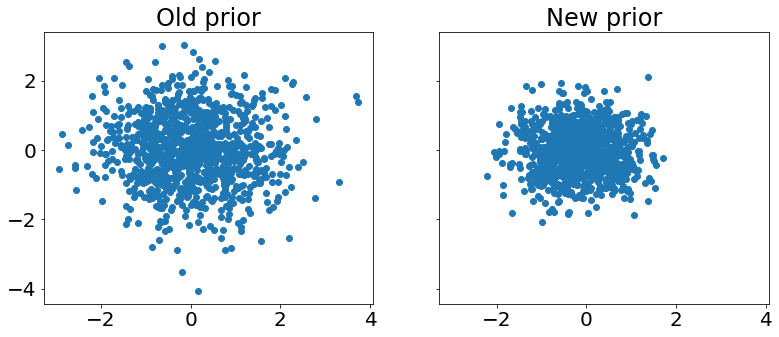

In [23]:
### Plot new prior
prior_old = args.std_normal.sample((1000, 2)).cpu().detach().numpy()

prior_new = mu_init_wo + args.std_normal.sample((1000, 2)) * nn.functional.softplus(sigma_init_wo)
prior_new = prior_new.cpu().detach().numpy()

fig, ax = plt.subplots(ncols=2, figsize=(13, 5), sharex=True, sharey=True)
ax[0].scatter(prior_old[:, 0], prior_old[:, 1])
ax[1].scatter(prior_new[:, 0], prior_new[:, 1])
ax[0].set_title('Old prior')
ax[1].set_title('New prior');

In [24]:
# n_samples = 10000
n_chains = 50
repetitions = 1

init_q = mu_init_wo + args.std_normal.sample((n_chains, args.z_dim)).requires_grad_(True) * nn.functional.softplus(sigma_init_wo)
q = init_q
our_samples = []
# our_samples.append(q.cpu().detach().numpy())

# init_p = args.std_normal.sample((n_samples, args.z_dim))
# p = init_p

for rep in range(repetitions):
    init_p = args.std_normal.sample((n_chains, args.z_dim))
    p = init_p
    cond_vectors = [args.std_normal.sample(init_p.shape) for _ in range(args.K)]
    for k in range(args.K):
        if args.amortize:
            q, p, _, _, _, _ = our_kernel_best_wo.make_transition(q_old=q,
                                            p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
        else:
            q, p, _, _, _, _ = our_kernel_best_wo[k].make_transition(q_old=q,
                                                        p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
        our_samples.append(q.cpu().detach().numpy())

In [25]:
our_samples = np.array(our_samples)

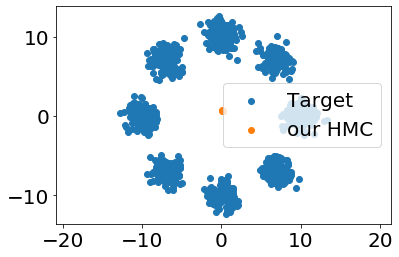

In [26]:
chain_ind = 11


plt.scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
plt.scatter(our_samples[:, chain_ind, 0], our_samples[:, chain_ind, 1], label='our HMC')
# plt.xlim((-4, 4))
# plt.ylim((-4, 4))
plt.axis('equal')
plt.legend();


100%|██████████| 5/5 [00:00<00:00, 74.18it/s]


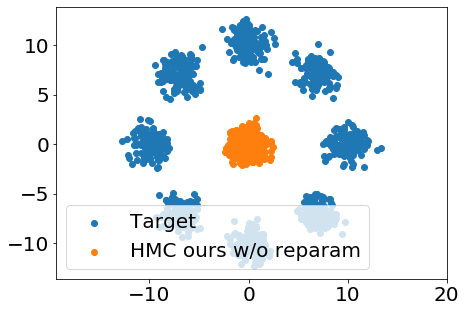

In [27]:
q_new = mu_init_wo + args.std_normal.sample((target_samples.shape[0], args.z_dim)) * nn.functional.softplus(sigma_init_wo)
p_new = args.std_normal.sample((target_samples.shape[0], args.z_dim))

iterator = tqdm(range(args.n_steps))

for i in iterator:
    cond_vectors = [args.std_normal.sample(p_new.shape) for k in range(args.K)]
    if args.amortize:
        q_new, p_new, _, _, a, _ = our_kernel_best_wo.make_transition(q_old=q_new, p_old=p_new, target_distr=target, k=cond_vectors[i])
    else:
        q_new, p_new, _, _, a, _ = our_kernel_best_wo[i].make_transition(q_old=q_new, p_old=p_new, target_distr=target, k=cond_vectors[i])
iterator.close()

plt.figure(figsize=(7, 5))
plt.scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
plt.scatter(q_new.cpu().detach().numpy()[:, 0], q_new.cpu().detach().numpy()[:, 1], label='HMC ours w/o reparam')
plt.legend()
plt.axis('equal');

## Ours HMC (with reparametrization trick)

In [7]:
if args.learnable_reverse:
    reverse_kernel = Reverse_kernel_sampling(kwargs=args).to(args.device)
    reverse_params = reverse_kernel.parameters()
else:
    reverse_params = list([])

if args.amortize:
    transitions = HMC_our(kwargs=args).to(args.device)
    our_kernel_best_w = HMC_our(kwargs=args).to(args.device)
else:
    transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])
    our_kernel_best_w = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args.K)])
        
if args.fix_transition_params:
    for p in transitions.parameters():
        transitions.requires_grad_(False)
    
mu_init_w = nn.Parameter(torch.zeros(args.data_dim, device=args.device, dtype=args.torchType))
sigma_init_w = nn.Parameter(torch.ones(args.data_dim, device=args.device, dtype=args.torchType))

params = list(transitions.parameters()) + list(reverse_params) + [mu_init_w, sigma_init_w]

optimizer = torch.optim.Adam(params=params, lr=args.learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=200, factor=0.9)

  0%|          | 0/20000 [00:00<?, ?it/s]

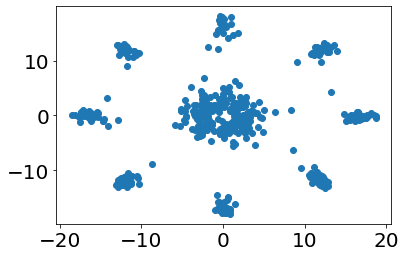

  0%|          | 1/20000 [00:03<21:50:36,  3.93s/it]

Current lr:  0.001
On batch number 0 ELBO is -68.28801727294922
On batch number 0 Best ELBO is -inf


  1%|          | 193/20000 [12:44<21:44:42,  3.95s/it]

In [ ]:
# with torch.autograd.detect_anomaly():
print_info_ = 1000
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)
best_elbo = -float("inf")

x_lim = limit
y_lim = limit

def compute_loss(q_new, p_new, u, p_old, sum_log_alpha, sum_log_jac, all_directions=None, sum_log_sigma=None):
    if args.learnable_reverse:
        log_r = reverse_kernel(z_fin=q_new.detach(), a=all_directions)
    else:
        log_r = -args.K * torch_log_2
    log_p = target.get_logdensity(z=q_new) + args.std_normal.log_prob(p_new).sum(1)
    log_m = -sum_log_sigma + args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac + sum_log_alpha
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full.detach().mean().item(), grad_elbo


iterator = tqdm(range(args.num_batches))
cur_tolerance = 0
for batch_num in iterator:
    plt.close()
    cond_vectors = [args.std_normal.sample((args.train_batch_size, args.z_dim)) for k in range(args.K)]

    # sample initial q and p
    u = args.std_normal.sample((args.train_batch_size, args.z_dim))
    q_old = mu_init_w + u * nn.functional.softplus(sigma_init_w)
    p_old = args.std_normal.sample((args.train_batch_size, args.z_dim))
    sum_log_sigma = torch.sum(nn.functional.softplus(sigma_init_w).log())

    # prepare tensors for auxilary stuff
    sum_log_alpha = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
    sum_log_jacobian = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation

    q = q_old
    p = p_old
    if (batch_num) % print_info_ == 0:
        array_z = []
        array_directions = []
        array_alpha = []
        array_prop = []

    if args.learnable_reverse:
        all_directions = torch.tensor([], device=args.device)
    else:
        all_directions = None
        
     # run training cycle
    for k in range(args.K):
        if args.amortize:
            q, p, log_jac, current_log_alphas, directions, q_prop = transitions.make_transition(q_old=q,
                                            p_old=p, k=cond_vectors[k], target_distr=target)
        else:
            q, p, log_jac, current_log_alphas, directions, q_prop = transitions[k].make_transition(q_old=q,
                                                        p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
#         if (batch_num) % print_info_ == 0:
#             print('On batch number {} and on k = {} we have for 0: {} and for +1: {}'.format(batch_num, k + 1,
#                                                         (directions==0.).to(float).mean(), (directions==1.).to(float).mean()))
#             print('Step size for {}-th transition is {}'.format(k, transitions[k].gamma.detach().exp()))
#             print('Alpha (ref) for {}-th transition is {}'.format(k, torch.sigmoid(transitions[k].alpha_logit.detach())))
        sum_log_alpha = sum_log_alpha + current_log_alphas
        sum_log_jacobian = sum_log_jacobian + log_jac
        if (batch_num) % print_info_ == 0:
            array_z.append(q.detach())
            array_directions.append(directions.detach())
            array_alpha.append(current_log_alphas.detach())
            array_prop.append(q_prop.detach())
        if args.learnable_reverse:
            all_directions = torch.cat([all_directions, directions.detach().view(-1, 1)], dim=1)
    elbo_full, grad_elbo = compute_loss(q_new=q, p_new=p, u=u, p_old=p_old, sum_log_jac=sum_log_jacobian,
                                            sum_log_alpha=sum_log_alpha, all_directions=all_directions, sum_log_sigma=sum_log_sigma)
    if (batch_num ) % print_info_ == 0:
        plt.scatter(q.cpu().detach()[:, 0], q.cpu().detach()[:, 1])
        plt.show();
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
        print('Current lr: ', current_lr)
        print('On batch number {} ELBO is {}'.format(batch_num, elbo_full))
        print('On batch number {} Best ELBO is {}'.format(batch_num, best_elbo))
#         fig, ax = plt.subplots(ncols=args.K, figsize=(30, 10))
#         label = ['Same', 'Forward']
#         for kk in range(args.K):
#             ax[kk].scatter(array_prop[kk][:, 0].cpu().numpy(), array_prop[kk][:, 1].cpu().numpy(), color='r', label='Proposals')
#             for d in [0., 1.]:
#                 z_c = array_z[kk][array_directions[kk]==d]
#                 alpha_c = array_alpha[kk][array_directions[kk]==d].cpu().exp().numpy()
#                 color = np.zeros((z_c.shape[0], 4))
#                 color[:, 3] = alpha_c
#                 color[:, int(d + 1)] = 1.
#                 ax[kk].scatter(z_c[:, 0].cpu().numpy(), z_c[:, 1].cpu().numpy(), color=color, label=label[int(d)])
# #                 ax[kk].set_xlim((-x_lim, x_lim))
# #                 ax[kk].set_ylim((-y_lim, y_lim))
#                 ax[kk].legend()
        plt.show();
    (-grad_elbo).backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(elbo_full)

    if np.isnan(elbo_full):
        print('NAN appeared!')
        iterator.close()
        raise ValueError

    if elbo_full > best_elbo:
        best_elbo = elbo_full
        our_kernel_best_w.load_state_dict(transitions.state_dict())
        cur_tolerance = 0
    else:
        cur_tolerance += 1
        if cur_tolerance >= args.early_stopping_tolerance:
            print('Early stopping on {}'.format(batch_num))
            iterator.close()
            break

In [ ]:
q_new = mu_init_w + args.std_normal.sample((target_samples.shape[0], args.z_dim)) * nn.functional.softplus(sigma_init_w)
p_new = args.std_normal.sample((target_samples.shape[0], args.z_dim))

iterator = tqdm(range(args.n_steps))

for i in iterator:
    cond_vectors = [args.std_normal.sample(p_new.shape) for k in range(args.K)]
    if args.amortize:
        q_new, p_new, _, _, a, _ = our_kernel_best_w.make_transition(q_old=q_new, p_old=p_new, target_distr=target, k=cond_vectors[i])
    else:
        q_new, p_new, _, _, a, _ = our_kernel_best_w[i].make_transition(q_old=q_new, p_old=p_new, target_distr=target, k=cond_vectors[i])
iterator.close()

plt.figure(figsize=(7, 5))
plt.scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
plt.scatter(q_new.cpu().detach().numpy()[:, 0], q_new.cpu().detach().numpy()[:, 1], label='HMC ours with reparam')
plt.legend()
plt.axis('equal');

In [ ]:
### Plot new prior
prior_old = args.std_normal.sample((1000, 2)).cpu().detach().numpy()

prior_new = mu_init_w + args.std_normal.sample((1000, 2)) * nn.functional.softplus(sigma_init_w)
prior_new = prior_new.cpu().detach().numpy()

fig, ax = plt.subplots(ncols=2, figsize=(13, 5), sharex=True, sharey=True)
ax[0].scatter(prior_old[:, 0], prior_old[:, 1])
ax[1].scatter(prior_new[:, 0], prior_new[:, 1])
ax[0].set_title('Old prior')
ax[1].set_title('New prior');

In [ ]:
for p in our_kernel_best_w.parameters():
    p.requires_grad_(False)
    
mu_init_w.requires_grad_(False)
sigma_init_w.requires_grad_(False)

# All samples

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 15), dpi=300, sharex=True, sharey=True)

target_samples = target.get_samples(n=100000).cpu().numpy()
u = args.std_normal.sample((target_samples.shape[0], args.z_dim))

##### Vanilla HMC

q_new = u #args.std_normal.sample((target_samples.shape[0], args.z_dim))
p_new = args.std_normal.sample((target_samples.shape[0], args.z_dim))

iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
iterator.close()

samples_hmc = q_new.cpu().detach().numpy()

###### Hoffman HMC

q_new = mu_init_hoff + u * nn.functional.softplus(sigma_init_hoff)
p_new = args.std_normal.sample((target_samples.shape[0], args.z_dim))

iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
iterator.close()

samples_hoff = q_new.cpu().detach().numpy()


####### Neutra HMC

q_new = u
p_new = args.std_normal.sample((target_samples.shape[0], args.z_dim))

iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target, flows=flows)
iterator.close()

q_new = q_new.detach()
for j in range(len(flows)):
    q_new = flows[j](q_new)

samples_neutrahmc = q_new.cpu().detach().numpy()


###### Ours without reparam

q_new = mu_init_wo + u * nn.functional.softplus(sigma_init_wo)
p_new = args.std_normal.sample((target_samples.shape[0], args.z_dim))

iterator = tqdm(range(args.n_steps))
for i in iterator:
    cond_vectors = [args.std_normal.sample(p_new.shape) for k in range(args.K)]
    if args.amortize:
        q_new, p_new, _, _, a, _ = our_kernel_best_wo.make_transition(q_old=q_new, p_old=p_new, target_distr=target, k=cond_vectors[i])
    else:
        q_new, p_new, _, _, a, _ = our_kernel_best_wo[i].make_transition(q_old=q_new, p_old=p_new, target_distr=target, k=cond_vectors[i])
iterator.close()

samples_wo = q_new.cpu().detach().numpy()

###### Ours with reparam

q_new = mu_init_w + u * nn.functional.softplus(sigma_init_w)
p_new = args.std_normal.sample((target_samples.shape[0], args.z_dim))

iterator = tqdm(range(args.n_steps))
for i in iterator:
    cond_vectors = [args.std_normal.sample(p_new.shape) for k in range(args.K)]
    if args.amortize:
        q_new, p_new, _, _, a, _ = our_kernel_best_w.make_transition(q_old=q_new, p_old=p_new, target_distr=target, k=cond_vectors[i])
    else:
        q_new, p_new, _, _, a, _ = our_kernel_best_w[i].make_transition(q_old=q_new, p_old=p_new, target_distr=target, k=cond_vectors[i])
iterator.close()

samples_w = q_new.cpu().detach().numpy()

lim_x = 2
lim_y = 2 * lim_x
lim_y_min = -2
alpha = 0.01

##### Plotting
plt.suptitle('K={}'.format(args.K))
ax[0, 0].set_title('HMC')
ax[0, 0].scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
ax[0, 0].scatter(samples_hmc[:, 0], samples_hmc[:, 1], label='HMC')
prior_samples = u
prior_samples = prior_samples.cpu().detach().numpy()
ax[0, 0].scatter(prior_samples[:, 0], prior_samples[:, 1], label='Prior', alpha=alpha)
# ax[0, 0].set_xlim((-x_lim, x_lim))
# ax[0, 0].set_ylim((lim_y_min, y_lim))
# ax[0, 0].set_aspect('equal', 'datalim')
ax[0, 0].legend()

ax[0, 1].set_title('HMC Hoffman')
ax[0, 1].scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
ax[0, 1].scatter(samples_hoff[:, 0], samples_hoff[:, 1], label='Hoffman')
prior_samples = mu_init_hoff + u * nn.functional.softplus(sigma_init_hoff)
prior_samples = prior_samples.cpu().detach().numpy()
ax[0, 1].scatter(prior_samples[:, 0], prior_samples[:, 1], label='Prior', alpha=alpha)
# ax[0, 1].set_xlim((-x_lim, x_lim))
# ax[0, 1].set_ylim((lim_y_min, y_lim))
# ax[0, 1].set_aspect('equal', 'datalim')
ax[0, 1].legend()

ax[1, 0].set_title('Ours without reparam')
ax[1, 0].scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
ax[1, 0].scatter(samples_wo[:, 0], samples_wo[:, 1], label='Without reparam')
prior_samples = mu_init_wo + u * nn.functional.softplus(sigma_init_wo)
prior_samples = prior_samples.cpu().detach().numpy()
ax[1, 0].scatter(prior_samples[:, 0], prior_samples[:, 1], label='Prior', alpha=alpha)
# ax[1, 0].set_xlim((-x_lim, x_lim))
# ax[1, 0].set_ylim((lim_y_min, y_lim))
# ax[1, 0].set_aspect('equal', 'datalim')
ax[1, 0].legend()

ax[1, 1].set_title('Ours with reparam')
ax[1, 1].scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
ax[1, 1].scatter(samples_w[:, 0], samples_w[:, 1], label='With reparam')
prior_samples = mu_init_w + u * nn.functional.softplus(sigma_init_w)
prior_samples = prior_samples.cpu().detach().numpy()
ax[1, 1].scatter(prior_samples[:, 0], prior_samples[:, 1], label='Prior', alpha=alpha)
# ax[1, 1].set_xlim((-x_lim, x_lim))
# ax[1, 1].set_ylim((lim_y_min, y_lim))
# ax[1, 1].set_aspect('equal', 'datalim')
ax[1, 1].legend();

ax[2, 0].set_title('Neutra HMC')
ax[2, 0].scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
ax[2, 0].scatter(samples_neutrahmc[:, 0], samples_neutrahmc[:, 1], label='Neutra HMC')
prior_samples = u.cpu().detach().numpy()
ax[2, 0].scatter(prior_samples[:, 0], prior_samples[:, 1], label='Prior', alpha=alpha)
# ax[1, 1].set_xlim((-x_lim, x_lim))
# ax[1, 1].set_ylim((lim_y_min, y_lim))
# ax[1, 1].set_aspect('equal', 'datalim')
ax[2, 0].legend();

plt.tight_layout()
plt.savefig('./pics_hmc/K_{}_N_{}_gamma_{}_alpha_{}_learnreverse_{}_fixparam_{}_amortize_{}_dataname_{}.png'.format(args.K, args.N, args.gamma, args.alpha,
                                                      args.learnable_reverse, args.fix_transition_params, args.amortize, args.data_name), format='png')

In [ ]:
import matplotlib.colors as mcolors
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), dpi=300)

norm=mcolors.PowerNorm(0.4)
bins = 1000
lim_x = 15
lim_y = 15
lim_y_min = -15

##### Plotting 2d Hists
plt.suptitle('K={}'.format(args.K))

ax[0, 0].set_title('HMC')
h, _, _ = np.histogram2d(samples_hmc[:, 0], samples_hmc[:, 1],
                             bins=bins, density=True, range=[[-lim_x, lim_x], [lim_y_min, lim_y]])
ax[0, 0].axis('off')
ax[0, 0].axis('equal')
ax[0, 0].imshow(np.rot90(h), interpolation='lanczos', norm=norm)

ax[0, 1].set_title('HMC Hoffman')
h, _, _ = np.histogram2d(samples_hoff[:, 0], samples_hoff[:, 1],
                             bins=bins, density=True, range=[[-lim_x, lim_x], [lim_y_min, lim_y]])
ax[0, 1].axis('off')
ax[0, 1].axis('equal')
ax[0, 1].imshow(np.rot90(h), interpolation='lanczos', norm=norm)

ax[1, 0].set_title('Ours without reparam')
h, _, _ = np.histogram2d(samples_wo[:, 0], samples_wo[:, 1],
                             bins=bins, density=True, range=[[-lim_x, lim_x], [lim_y_min, lim_y]])
ax[1, 0].axis('off')
ax[1, 0].axis('equal')
ax[1, 0].imshow(np.rot90(h), interpolation='lanczos', norm=norm)

ax[1, 1].set_title('Ours with reparam')
h, _, _ = np.histogram2d(samples_w[:, 0], samples_w[:, 1],
                             bins=bins, density=True, range=[[-lim_x, lim_x], [lim_y_min, lim_y]])
ax[1, 1].axis('off')
ax[1, 1].axis('equal')
ax[1, 1].imshow(np.rot90(h), interpolation='lanczos', norm=norm)


ax[2, 0].set_title('Neutra HMC')
h, _, _ = np.histogram2d(samples_neutrahmc[:, 0], samples_neutrahmc[:, 1],
                             bins=bins, density=True, range=[[-lim_x, lim_x], [lim_y_min, lim_y]])
ax[2, 0].axis('off')
ax[2, 0].axis('equal')
ax[2, 0].imshow(np.rot90(h), interpolation='lanczos', norm=norm)

ax[2, 1].axis('off')
ax[2, 1].axis('equal')

# plt.subplots_adjust(left=0.25, right=1., bottom=0., top=0.85, wspace=0.1, hspace=0.15)
plt.tight_layout();
plt.savefig('./pics_hmc/hist2d_K_{}_N_{}_gamma_{}_alpha_{}_learnreverse_{}_fixparam_{}_amortize_{}_dataname_{}.png'.format(args.K, args.N, args.gamma, args.alpha,
                                                      args.learnable_reverse, args.fix_transition_params, args.amortize, args.data_name), format='png')

In [ ]:

#     plt
#     plt.axis('off')
#     plt.axis('equal')